In [26]:
import os
from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torchvision import transforms


class CustomImageDataset(Dataset):
    def read_data_set(self):

        all_img_files = []
        all_labels = []

        class_names = os.walk(self.data_set_path).__next__()[1]

        for index, class_name in enumerate(class_names):
            label = index
            img_dir = os.path.join(self.data_set_path, class_name)
            img_files = os.walk(img_dir).__next__()[2]

            for img_file in img_files:
                img_file = os.path.join(img_dir, img_file)
                img = Image.open(img_file)
                if img is not None:
                    all_img_files.append(img_file)
                    all_labels.append(label)

        return all_img_files, all_labels, len(all_img_files), len(class_names)

    def __init__(self, data_set_path, transforms=None):
        self.data_set_path = data_set_path
        self.image_files_path, self.labels, self.length, self.num_classes = self.read_data_set()
        self.transforms = transforms

    def __getitem__(self, index):
        image = Image.open(self.image_files_path[index])
        image = image.convert("RGB")

        if self.transforms is not None:
            image = self.transforms(image)

        return image, self.labels[index]

    def __len__(self):
        return self.length

In [27]:
transforms_train = transforms.Compose([transforms.Resize((128, 128)),
                                       transforms.RandomRotation(10.),
                                       transforms.ToTensor()])

train_data_set = CustomImageDataset(data_set_path="/home/pranjal-ubuntu/Downloads/BrainTumorClassification/data", transforms=transforms_train)
train_loader = DataLoader(train_data_set, batch_size=8, shuffle=True)

In [28]:
batch=next(iter(train_loader))

In [29]:
images = batch[0]
labels = batch[1]

In [30]:
len(batch)

2

In [31]:
type(batch)

list

In [32]:
images.shape

torch.Size([8, 3, 128, 128])

In [33]:
labels.shape

torch.Size([8])

labels : tensor([1, 0, 0, 0, 1, 0, 1, 0])


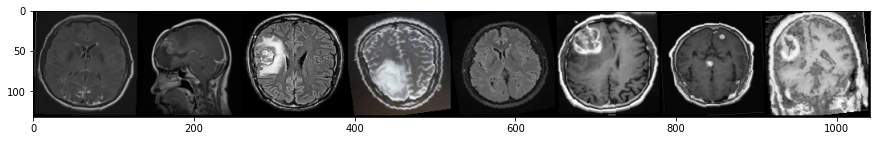

In [38]:
import torchvision
import matplotlib.pyplot as plt
import numpy as np
grid = torchvision.utils.make_grid(images,nrow=10)
plt.figure(figsize=(15,15))
plt.imshow(np.transpose(grid,(1,2,0)))
print(f"labels : {labels}")

In [42]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim